In [1]:
import pandas as pd


ignores = ['datetime', 'postgres_load_data', 'postgres_gucs_shared_memory_size', 
          'postgres_gucs_shared_memory_size_in_huge_pages', 
           'postgres_build_sha', 'postgres_build_compile_options']

ignores2 = [
    'machine_disk_block_device_settings_nr_hw_queues', 
#     'machine_disk_block_device_settings_read_ahead_kb',
    'machine_disk_block_device_settings_nr_requests', 
    'machine_disk_block_device_settings_queue_depth',
    'machine_disk_block_device_settings_max_sectors_kb', 'machine_disk_block_device_settings_scheduler', 
    'machine_disk_block_device_settings_wbt_lat_usec', 'machine_disk_block_device_settings_rotational',
    'machine_disk_filesystem_source', 
    'postgres_gucs_track_io_timing', 'machine_instance_huge_pages_size_kb',
    'machine_instance_mem_total_bytes', 'machine_instance_hostinfo_KernelVersion',
    'machine_instance_hostinfo_KernelRelease', 'machine_disk_io_latency',
    'benchmark_config_custom_filename', 
    'machine_disk_io_latency',
    'postgres_gucs_max_prepared_transactions',
    'benchmark_config_builtin_script'
#     'benchmark_config_time',
#     'postgres_gucs_min_wal_size',
#     'benchmark_config_transactions'
#     'postgres_pgbench_prewarm',
]

def print_filenames(runs):
    filenames = {run.id: run.filename for run in runs}
    pdf = pd.Series(filenames)
    pd.set_option('display.max_colwidth', None)
    print(pdf)

# TODO: rewrite this garbage
# Also, previously we wanted disk and instance information always in the title
# TODO: add size of memory to title
def run_db_size_gb(run, when):
    return int(int(run.stats[when]['db_size']) / 1024 / 1024 / 1024)

def run_sb_size_mb(run):
    sb_size = run.metadata.get('postgres_gucs_shared_buffers', None)
    if not sb_size:
        return None
    return int(int(sb_size) * 8192 / 1024 / 1024)

def mem_size_gb(run):
    mem_size_bytes = run.metadata.get('machine_instance_mem_total_bytes')
    return int(int(mem_size_bytes) / 1024 / 1024 / 1024)


def titular_db_size(runs):
    min_pre_size = run_db_size_gb(runs[0], 'post_load_pre_run')
    max_pre_size = 0
    min_post_size = run_db_size_gb(runs[0], 'post_load_post_run')
    max_post_size = 0
    
    sb_size = run_sb_size_mb(runs[0])
    
    for run in runs:
        cur_pre_size = run_db_size_gb(run, 'post_load_pre_run')
        cur_post_size = run_db_size_gb(run, 'post_load_post_run')
        if cur_pre_size < min_pre_size:
            min_pre_size = cur_pre_size
        if cur_pre_size > max_pre_size:
            max_pre_size = cur_pre_size
        if cur_post_size < min_post_size:
            min_post_size = cur_post_size
        if cur_post_size > max_post_size:
            max_post_size = cur_post_size
        
        if sb_size is None:
            continue 
        run_sb_size = run_sb_size_mb(run)

        if run_sb_size is None or sb_size != run_sb_size:
            sb_size = None
            continue
    
    mem_size = f'Machine Mem: {mem_size_gb(run)} GB.'
    
    sb_size_str = ''
    if sb_size is not None:
        if sb_size > 1024:
            sb_size_str = f'SB Size: {int(sb_size / 1024)} GB.'
        else:
            sb_size_str = f'SB Size: {sb_size} MB.'

    if min_pre_size == max_pre_size:
        before_str = f"Before DB Size: {min_pre_size}GB."
    else:
        before_str = f"Before DB Size: {min_pre_size}-{max_pre_size}GB."
        
    if min_post_size == max_post_size:
        after_str = f"After DB Size: {max_post_size}GB."
    else:
        after_str = f"After DB Size: {min_post_size}-{max_post_size}GB."

    return ' '.join([mem_size, sb_size_str, before_str, after_str])

In [2]:
from datetime import datetime, timedelta, timezone

def to_unique_list(store):
    result = []
    for name, vals in store.items():
        for val in vals:
            result.append(name + '_' + val)
    return result

def old_and_short(all_data):
    # exclude all data older than 1 day and shorter than 5 seconds
    # duration should be in seconds
    duration = all_data['data']['pgbench']['summary'].get('duration', None)
    if duration and duration < 40:
        return True
    datetime_str = all_data['metadata']['datetime']
    now = datetime.now(timezone.utc)
    runtime = datetime.fromisoformat(datetime_str)
    if now - runtime > timedelta(days=3, hours=1):
        return True
    return False

def scale_not_match(all_data):
    benchmark_config = all_data['metadata']['benchmark']['config']
    scale = benchmark_config.get('scale', None)
    if scale is None:
        return True
#     return scale != 1200 and scale != 3900
    return scale != 42

def cpufreq_not_null(all_data):
    instance = all_data['metadata']['machine']['instance']
    cpufreq_gov = instance.get('cpufreq_governor', None)
    return cpufreq_gov is None

def custom_filename_equals(all_data):
    config = all_data['metadata']['benchmark']['config']
    custom_filename = config.get('custom_filename', None)
    if custom_filename is None:
        return True
    if custom_filename.startswith('select'):
        return True
    return False

In [3]:
%reload_ext autoreload
%autoreload 2

from loader import Loader

load_root = 'run_data_local_fresh/backend_flush_after'

def pgbench_data_def(all_data):
    ys = ['tps', 'ts']
    data = all_data['data']['pgbench']['progress']
    rows = []
    for row in data:
        rows.append({k: v for k, v in row.items() if k in ys})
    return rows

def metadata_def(all_data):
    return all_data['metadata']

def stats(all_data):
    return all_data['stats']

loader = Loader(load_root)
# loader.discard(old_and_short)
# loader.discard(scale_not_match)
# loader.discard(cpufreq_not_null)
# loader.discard(custom_filename_equals)


runs = loader.run({'pgbench': pgbench_data_def}, metadata_def, stats, 'ts')

In [4]:
%reload_ext autoreload
%autoreload 2

from renderer import SubfigureRenderer
from benchart import BenchArt

relabels = {
    'machine_instance_hostinfo_Hostname': 'host',
    'machine_instance_hostinfo_KernelRelease': 'kernel',
    'machine_disk_block_device_settings_nr_hw_queues': '#hwq',
    'machine_disk_block_device_settings_nr_requests': 'nr_requests',
    'machine_disk_block_device_settings_read_ahead_kb': 'read_ahead_kb',
    'machine_disk_block_device_settings_queue_depth': 'queue_depth',
    'machine_disk_block_device_settings_scheduler': 'scheduler',
    'machine_instance_hostinfo_Hostname': 'host',
    'benchmark_config_scale': 'pgbench_scale',
    'postgres_gucs_backend_flush_after': 'backend_flush_after',
    'postgres_gucs_shared_buffers': 'shared_buffers',
}

benchart = BenchArt(runs)

# TODO: make sure this all still works as intended
# benchart.part(SubfigureRenderer(relabels), 'benchmark_config_scale')
# benchart.part(SubfigureRenderer(relabels), 'postgres_gucs_shared_buffers')
# benchart.versus('postgres_gucs_backend_flush_after', 'postgres_gucs_shared_buffers')
# benchart.ignore(*ignores, *ignores2)
# benchart.versus( 'postgres_gucs_wal_buffers_full')
# benchart.versus('postgres_gucs_wal_segment_size')
# benchart.versus('benchmark_config_mode')
# benchart.versus('postgres_pgbench_prewarm')
# benchart.versus('postgres_gucs_shared_buffers')


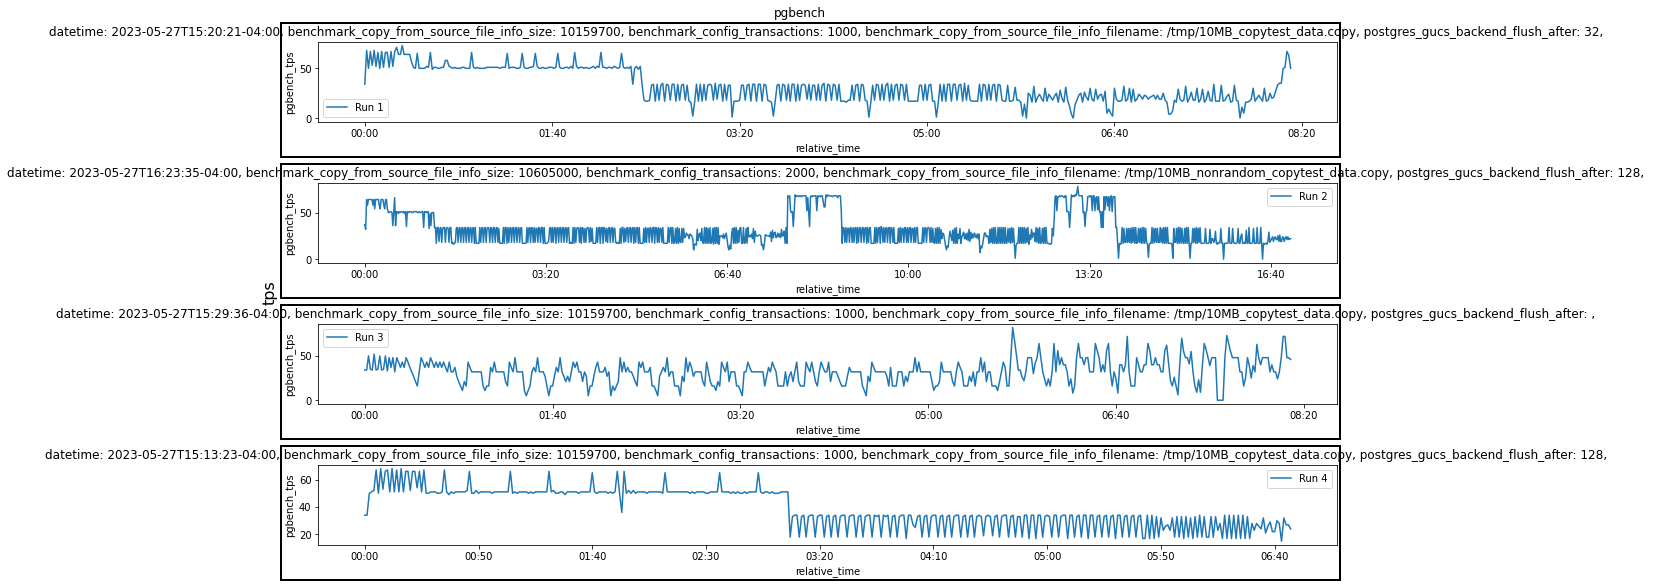

In [5]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from renderer import render, SubfigureRenderer

figure = plt.figure(figsize=(15,8), constrained_layout=True)
figure.suptitle('pgbench')
figure.supylabel('tps', fontsize=16)

root, title = render(benchart, figure, timebounds=(0,None), relabels=relabels)

In [6]:
%reload_ext autoreload
%autoreload 2

from loader import Loader
from datetime import datetime, timezone

# TODO: refactor some of the repetitition around checking
# if the keys are in the keys list and making the new list of rows
def iostat_data_def(all_data):
    iostat_ys = [ 'r/s', 'w/s', 'rkB/s', 'wkB/s', 'rrqm/s', 'wrqm/s', 'rrqm','wrqm',
               'r_await','w_await', 'rareq-sz','wareq-sz','aqu-sz','util', 'ts', 'user',
                'system', 'f/s']
    storage_io = []
    iostat_data = all_data['data'].get('iostat', None)
    for row in iostat_data:
        storage_row = row['disk'][0]
        storage_row['ts'] = row['timestamp']
        cpu_row = row['avg-cpu']
        new_cpu_row = {k:v for k, v in cpu_row.items() if k in iostat_ys}
        new_storage_row = {k:v for k, v in storage_row.items() if k in iostat_ys}
        new_storage_row.update(new_cpu_row)
        storage_io.append(new_storage_row)
    return storage_io

def pgbench_data_def(all_data):
    ys = ['tps', 'ts', 'tps_cumulative', 'lat']
    data = all_data['data']['pgbench']['progress']
    rows = []
    tps_sum = 0
    for row in data:
        tps_sum += int(row['tps'])
        row['tps_cumulative'] = tps_sum
        rows.append({k: v for k, v in row.items() if k in ys})
    return rows

def meminfo_data_def(all_data):
#     meminfo_ys = ['dirty_kb', 'writeback_kb','ts']
    meminfo_ys = ['dirty_kb', 'writeback_kb','mem_free_kb', 'mem_available_kb','ts']

    dirtywriteback = all_data['data'].get('dirtywriteback', None)
    # dirtywriteback was renamed to meminfo
    meminfo = all_data['data'].get('meminfo', None)
    if meminfo is None and dirtywriteback is None:
        return None
    data = meminfo if meminfo is not None else dirtywriteback
    rows = []
    for row in data:
        new_row = {k:v for k, v in row.items() if k in meminfo_ys}
        rows.append(new_row)
    return rows

def metadata_def(all_data):
    return all_data['metadata']

def stats(all_data):
    return all_data['stats']

# Note that this only works if run in the same timezone as the pidstat command was run in
def pidstat_data_def(all_data):
    pidstat_ys = ['kB_wr/s','ts']
    pidstat = all_data['data'].get('pidstat', None)
    if not pidstat:
        return None
    if not isinstance(pidstat, list):
        return None
    tz = datetime.now(timezone.utc).astimezone().tzinfo
    procname = pidstat[0]['name']
    pidstat = pidstat[0]['data']
    rows = []
    for row in pidstat:
        new_row = {procname + '_' + k:v for k, v in row.items() if k in pidstat_ys and k != 'ts'}
        new_row['ts'] = datetime.fromtimestamp(int(row['ts']), tz)
        rows.append(new_row)
    return rows

def walstat_data_def(all_data):
    wal_stat_ys = ['ts', 'wal_buffers_full', 'wal_bytes', 'wal_sync', 'wal_fpi',
                  'wal_sync_time', 'wal_write_time']
    wal_stat_progress = all_data['data'].get('walstat', None)
    rows = []
    if wal_stat_progress is None:
        return None
    for row in wal_stat_progress:
        for k, v in row.items():
            if k == 'ts' or k == 'stats_reset':
                continue
            row[k] = int(row[k])        
        new_row = {k: v for k, v in row.items() if k in wal_stat_ys}
        rows.append(new_row)
    return rows

def iocheckpointerstat_data_def(all_data):
    cp_stat_ys = ['ts', 'writes', 'write_time', 'fsyncs', 'fsync_time',
                  'writebacks', 'writeback_time']
    progress = all_data['data'].get('iocheckpointerstat', None)
    if progress is None:
        return None
    rows = []
    for row in progress:
        for k, v in row.items():
            if k not in cp_stat_ys or k == 'ts':
                continue
            if k.endswith('time'):
                row[k] = float(row[k])
            else:
                row[k] = int(row[k])
        new_row = {k: v for k, v in row.items() if k in cp_stat_ys}
        rows.append(new_row)
    return rows
    
def autovac_chr_data_def(all_data):
    data = all_data['data'].get('pgiostat', None)
    if data is None:
        return None
    rows = []
    for row in data:
        if row['backend_type'] != 'autovacuum worker':
            continue
        if row['object'] != 'relation' or row['context'] != 'vacuum':
            continue
        hits = int(row['hits'])
        reads = int(row['reads'])
        if hits + reads == 0:
            cache_hit_ratio = 0
        else:
            cache_hit_ratio = hits / (hits + reads)
        new_row = {} 
        new_row['cache_hit_ratio'] = cache_hit_ratio
        new_row['ts'] = row['ts']
        rows.append(new_row)
    return rows
    
def backend_chr_data_def(all_data):
    data = all_data['data'].get('pgiostat', None)
    if data is None:
        return None
    rows = []
    for row in data:
        if row['backend_type'] != 'client backend':
            continue
        if row['object'] != 'relation' or row['context'] != 'normal':
            continue
        hits = int(row['hits'])
        reads = int(row['reads'])
        if hits + reads == 0:
            cache_hit_ratio = 0
        else:
            cache_hit_ratio = hits / (hits + reads)
        new_row = {} 
        new_row['cache_hit_ratio'] = cache_hit_ratio
        new_row['ts'] = row['ts']
        rows.append(new_row)
    return rows
    
def relation_size_data_def(all_data):
    data = all_data['data'].get('relationsize', None)
    if data is None:
        return None
    rows = []
    for row in data:
        new_row = {}
        new_row['relation_size'] = int(row['relation_size'])
        new_row['ts'] = row['ts']
        rows.append(new_row)
    return rows
    
def buffercache_data_def(all_data):
    data = all_data['data'].get('buffercache', None)
    if data is None:
        return None
    rows = []
    for row in data:
        for k, v in row.items():
            if k == 'ts':
                continue
            if k == 'usagecount_avg':
                row[k] = float(row[k])
            else:
                row[k] = int(row[k])
        rows.append(row)
    if not rows:
        return None
    return rows
    
def aggwaits_data_def(all_data):
    data = all_data['data'].get('waits', None)
    if data is None:
        return None
    rows = []
    for row in data:
        col = row['wait_event_type'] + '_' + row['wait_event']
        new_row = {}
        new_row[col] = int(row['count'])
        new_row['ts'] = row['ts']
        rows.append(new_row)
    return rows
    
data_exprs = {'pgbench': pgbench_data_def, 'iostat':iostat_data_def,
              'meminfo':meminfo_data_def, 'pidstat': pidstat_data_def,
             'walstat': walstat_data_def, 'iocheckpointerstat': iocheckpointerstat_data_def,
             'buffercache': buffercache_data_def, 'waits': aggwaits_data_def,
             'autovaccachehitratio': autovac_chr_data_def,
             'backendcachehitratio': backend_chr_data_def,
             'relationsize': relation_size_data_def}

loader = Loader(load_root)

# loader.discard(old_and_short)
# loader.discard(scale_not_match)
# loader.discard(cpufreq_not_null)
# loader.discard(custom_filename_equals)


runs = loader.run(data_exprs, metadata_def, stats, 'ts')

In [7]:
%reload_ext autoreload
%autoreload 2

from benchart import BenchArt

benchart = BenchArt(runs)

# benchart.part(None, 'benchmark_config_scale')
# benchart.part(None, 'postgres_gucs_shared_buffers')
benchart.ignore(*ignores, *ignores2)
benchart.versus('postgres_gucs_backend_flush_after')
# benchart.versus('postgres_gucs_shared_buffers')
# benchart.versus('machine_instance_cpufreq_governor')
# benchart.versus('postgres_gucs_huge_pages')
# benchart.versus('postgres_gucs_wal_buffers')
# benchart.versus('postgres_gucs_wal_segment_size', 
#                 'postgres_init', 'postgres_pause_after_load')
# benchart.versus('postgres_init', 'postgres_pause_after_load')
# benchart.versus('machine_disk_block_device_settings_read_ahead_kb', 'machine_disk_dmdelay')
# benchart.versus('machine_disk_block_device_settings_read_ahead_kb')

# benchart.versus('postgres_gucs_wal_compression')
# benchart.versus('postgres_gucs_autovacuum_vacuum_cost_delay')
# benchart.versus('benchmark_config_mode')
# benchart.versus('postgres_pgbench_prewarm')
# benchart.versus('benchmark_config_custom_filename', 'postgres_gucs_shared_buffers')
# benchart.versus('benchmark_data_distribution')


Run: 1. filename: run_data_local_fresh/backend_flush_after/7bfea9e7-94bf-4517-a0dc-cd564dc78b7f.json
Run: 3. filename: run_data_local_fresh/backend_flush_after/10ef1016-36d0-47a7-8523-9a60f2e87253.json
Run: 4. filename: run_data_local_fresh/backend_flush_after/1e87a19c-105e-468f-8246-5740b76c0a38.json
Run: 2. filename: run_data_local_fresh/backend_flush_after/071cbf60-2881-4875-89c7-e8ffac3c5110.json
postgres_gucs_maintenance_work_mem:1048576

postgres_gucs_checkpoint_timeout:180

postgres_gucs_track_io_timing:on

postgres_gucs_shared_memory_size:21999

postgres_gucs_max_connections:1000

postgres_gucs_shared_buffers:2621440

postgres_gucs_max_wal_size:204800

postgres_gucs_wal_buffers:131072

postgres_gucs_max_stack_depth:2048

postgres_gucs_huge_pages:on

postgres_gucs_autovacuum_vacuum_cost_delay:1

postgres_gucs_min_wal_size:204800

postgres_gucs_shared_memory_size_in_huge_pages:11000



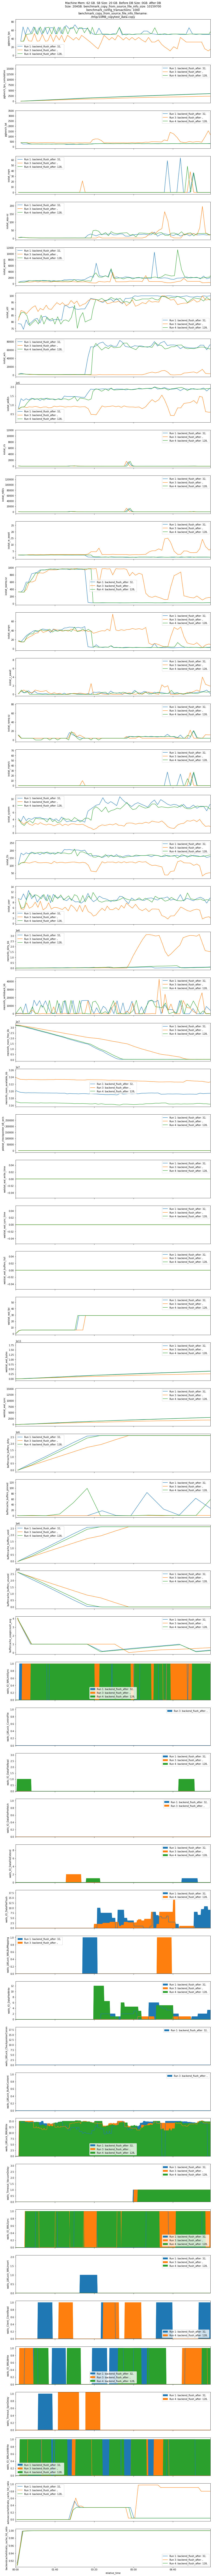

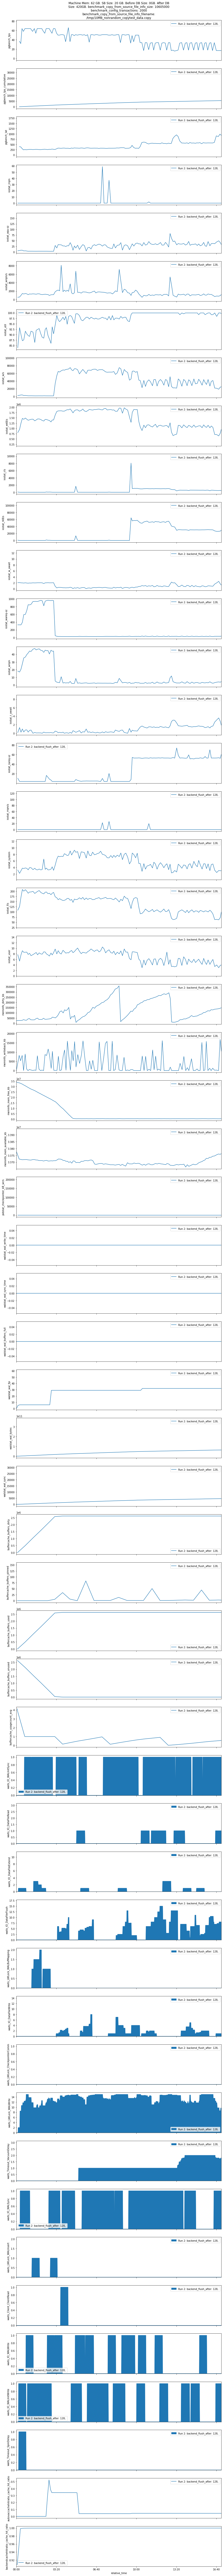

In [8]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from renderer import render_multi, render_print_tree

skip_keys = ['postgres_gucs_unix_socket_permissions', 'postgres_gucs_server_encoding',
                 'postgres_gucs_application_name', 'postgres_gucs_TimeZone', 
             'postgres_gucs_data_directory_mode',
             'postgres_gucs_archive_command', 'postgres_gucs_client_encoding', 
             'postgres_gucs_log_file_mode',
             'postgres_gucs_log_timezone', 'postgres_gucs_default_text_search_config', 
            ]

# root = benchart.run()
# render_print_tree(root, occludes=benchart.ignores)

sorted_prefixes = ['pgbench', 'iostat', 'meminfo', 'pidstat', 
                   'walstat', 'iocheckpointerstat',
                  'buffercache', 'waits', 'autovaccachehitratio',
                  'backendcachehitratio', 'relationsize']

def axes_expr(axes):
    axes['iostat_wrqm'].set_yscale('log')
#     axes['iostat_rrqm'].set_yscale('log')
#     axes['iostat_rrqm/s'].set_yscale('log')
    axes['iostat_wrqm'].set_yscale('log')
    axes['iostat_wrqm/s'].set_yscale('log')
    axes['iostat_r_await'].set_yscale('log')
    axes['iostat_w_await'].set_yscale('log')
    
def fake_axes_expr(axes):
    pass

figwidth = 15
timebounds=(0,None)
root, title = render_multi(benchart, figwidth, sorted_prefixes, timebounds, relabels,
                           titular_db_size, fake_axes_expr)

for k, v in root.metadata.items():
    gpl = k.split('_')

    if gpl[0] != 'postgres' or gpl[1] != 'gucs':
        continue
    if gpl[2] == 'lc':
        continue
    if k in skip_keys:
        continue
    print(f'{k}:{v}\n')

# plt.savefig('example.png', transparent=False, facecolor='white', edgecolor='white')

### 